# Ler e Entender os dados

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
pd.options.mode.chained_assignment = None


## Carregando o dataframe

In [2]:
base_folder = os.getcwd()
for dirname, _, filenames in os.walk(os.path.join(base_folder, 'input')):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/lucashelal/Workspace/retail_case/input/comp_prices.csv
/Users/lucashelal/Workspace/retail_case/input/sales.csv


In [3]:
df_comp_price = pd.read_csv(os.path.join(base_folder,'input/comp_prices.csv'))

## Contéudo do Dataframe

comp_prices.csv

> PROD_ID:  ID do produto. Contém 9 diferentes produtos (P1 - P9).

> DATE_EXTRACTION: Data e Hora da extração dos dados dos concorrentes. Formato: YYYY-MM-DD HH:MM:SS

> COMPETITOR: ID dos concorrentes. Contém6 diferentes produtos (C1 - C6).

> COMPETITOR_PRICE: Preços dos Concorrentes por produto, no qual pode depender do meio de pagamento (PAY_TYPE).

> PAY_TYPE:  Meio de Pagamento (1- Pagamento diferido, 2- Pagamento imediato)

In [4]:
df_comp_price.head()

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE
0,P6,2015-01-30 08:11:38,C3,1898.00,1
1,P6,2015-01-30 08:11:38,C1,1898.00,1
2,P6,2015-01-30 08:11:38,C6,1999.90,1
3,P6,2015-01-31 20:10:14,C2,1894.88,2
4,P6,2015-01-31 20:10:14,C3,1894.88,2


In [5]:
df_comp_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50114 entries, 0 to 50113
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PROD_ID           50114 non-null  object 
 1   DATE_EXTRACTION   50114 non-null  object 
 2   COMPETITOR        50114 non-null  object 
 3   COMPETITOR_PRICE  50114 non-null  float64
 4   PAY_TYPE          50114 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.9+ MB


> Neste ponto já possível observar que não temos nenhuma coluna que tenha algum de seus atributos vazio.

## Descrição do Dataframe

In [6]:
df_comp_price.describe()

,COMPETITOR_PRICE,PAY_TYPE
count,50114.000000,50114.000000
mean,1111.281449,1.499701
std,3805.613500,0.500005
min,359.100000,1.000000
25%,549.000000,1.000000
50%,799.000000,1.000000
75%,1359.000000,2.000000
max,149900.000000,2.000000


# Tratamento e Limpeza dos dados

## Função que permite a visualização dos produtos por seus respectivos valores unitários

In [7]:
def plot_boxplot(df_plt, x_plt, y_plt, order_plt):
    plt.rcParams['figure.figsize'] = [10,8]
    sns.boxplot(data = df_plt, x=x_plt, y=y_plt, order=order, orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
    # plt.title("", fontsize = 14, fontweight = 'bold')
    plt.ylabel(x_plt, fontweight = 'bold')
    plt.xlabel(y_plt, fontweight = 'bold')

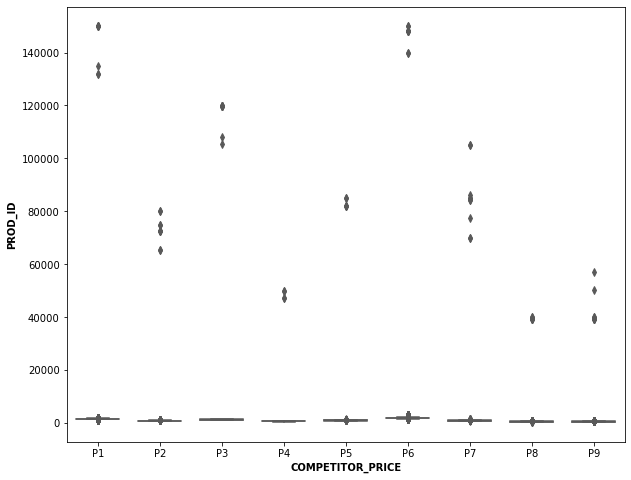

In [8]:
x='PROD_ID' 
y='COMPETITOR_PRICE'
order=['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']
plot_boxplot(df_comp_price, x, y, order)


Percebe-se que temos uma quantidade grande de outliers nesses preços, pode ser em algum momento/dia em que foram coletados os valores, pode ter ocorrido algum erro.

## Remover possíveis outliers por produto

In [9]:
def remove_outliers_sales(df, col_id, col_outlier):
    column_ID = df[col_id].unique()
    for i in (column_ID):
        df_loc_col = df.loc[df[col_id] == i][col_outlier]
        Q1 = df_loc_col.quantile(0.05)
        Q3 = df_loc_col.quantile(0.95)
        IQR = Q3 - Q1
        
        _filter = (df_loc_col >= Q1 - 1.5*IQR) & (df_loc_col <= Q3 + 1.5*IQR)

        df.loc[df[col_id] == i, [col_outlier]] = df_loc_col.loc[_filter]

In [10]:
df = df_comp_price.copy()

remove_outliers_sales(df, col_id = 'PROD_ID', col_outlier = 'COMPETITOR_PRICE')

In [11]:
outliers = df_comp_price['COMPETITOR_PRICE'].count() - df['COMPETITOR_PRICE'].count()
print('Foram removidos {} outliers'.format(outliers))

Foram removidos 82 outliers


### Removendo do dataframe as colunas que ficaram com null

In [12]:
df = df.dropna()
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50032 entries, 0 to 50031
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PROD_ID           50032 non-null  object 
 1   DATE_EXTRACTION   50032 non-null  object 
 2   COMPETITOR        50032 non-null  object 
 3   COMPETITOR_PRICE  50032 non-null  float64
 4   PAY_TYPE          50032 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.9+ MB


### Visualização dos produtos por preço unitário s/ outliers

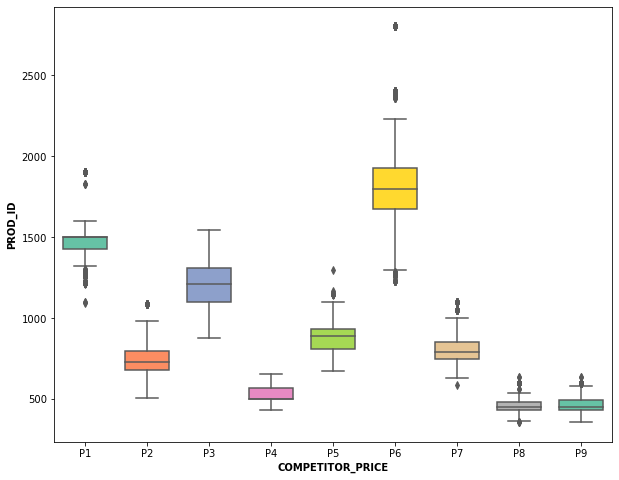

In [13]:
plot_boxplot(df, x, y, order)

Agora eliminando os devidos rúidos dos valores de venda, já podemos olhar pra P6 e ver que ele tem a maior média, P8 e P9 menores médias.

# Preparação dos dados

## Normalizar Colunas

In [14]:
def normalize_col(df, col_name):
    
    norm = df[[col_name]].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    
    x_scaled = min_max_scaler.fit_transform(norm)
    new_col_name = col_name + '_NORMALIZED'
    
    df_normalized = pd.DataFrame(x_scaled)
    df[[new_col_name]] = df_normalized

### Adicionando colunas mês e dia e hora (MONTH / DAY / HOUR)


In [15]:
df['DATE_EXTRACTION'] =  pd.to_datetime(df['DATE_EXTRACTION'], format='%Y-%m-%d %H:%M:%S')

df['MONTH'] = df['DATE_EXTRACTION'].dt.month
df['DAY'] = df['DATE_EXTRACTION'].dt.weekday
df['HOUR'] = df['DATE_EXTRACTION'].dt.hour

In [16]:
df.head()

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE,MONTH,DAY,HOUR
0,P6,2015-01-30 08:11:38,C3,1898.00,1,1,4,8
1,P6,2015-01-30 08:11:38,C1,1898.00,1,1,4,8
2,P6,2015-01-30 08:11:38,C6,1999.90,1,1,4,8
3,P6,2015-01-31 20:10:14,C2,1894.88,2,1,5,20
4,P6,2015-01-31 20:10:14,C3,1894.88,2,1,5,20


### Mapeamento dos valores das datas


In [17]:
# Mapeamento dos valores das datas

# Months = {1:'Jan',2:'Feb',3:'Mar', 4:'Apr', 5:'Mai', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Out'}
# Weekday = {0:"Seg", 1:"Ter", 2:"Qua", 3:"Qui", 4:"Sex", 5:"Sab", 6:"Dom"}

# df['MONTH'].replace(Months, inplace=True) 
# df['DAY'].replace(Weekday, inplace=True)


# Análise dos dados

O objetivo aqui é responder:


1. Qual a quantidade de vendas por produto em cada competidor?

2. Qual o tipo de pagamento utilizado em cada produto?

3. Quais Competidores tem o melhor e pior preço para cada produto?

4. Qual dias da semana tem maior volume de vendas?

5. Qual mês tem maior volume de vendas?



## Qual a quantidade de vendas por produto em cada competidor?

Vendas por produto:  P1


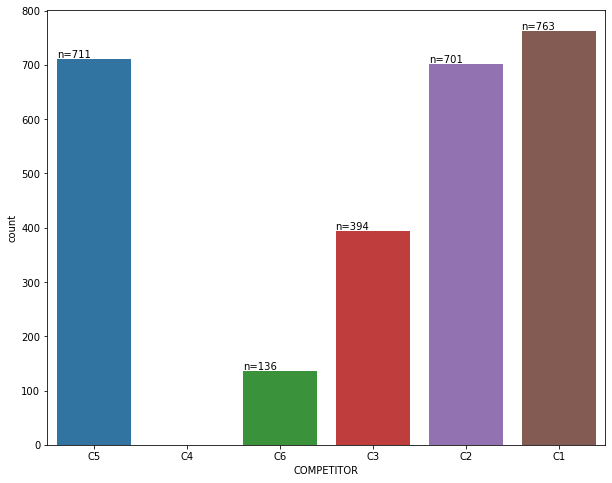

Vendas por produto:  P2


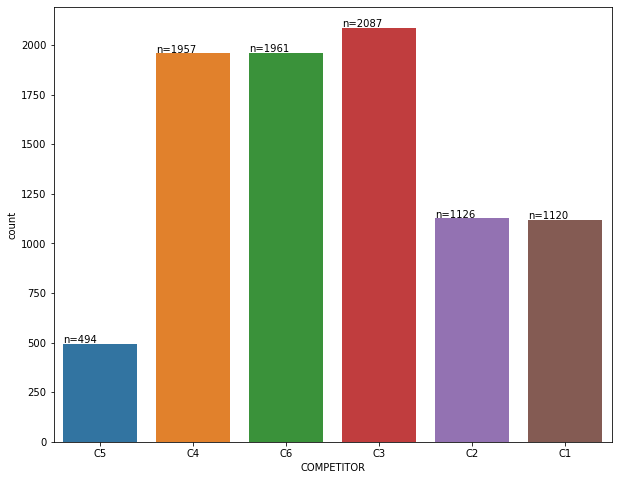

Vendas por produto:  P3


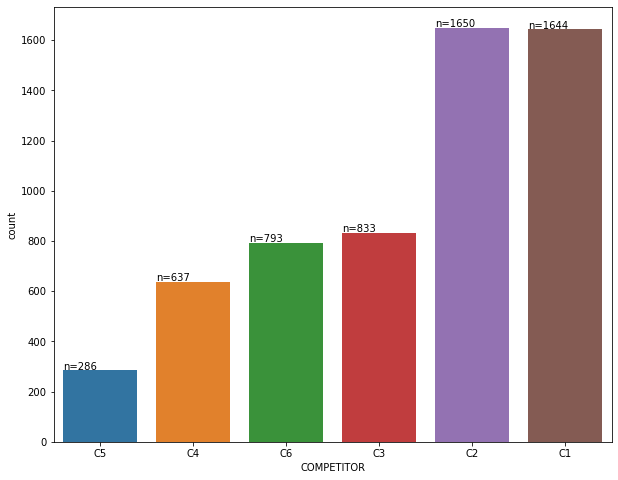

Vendas por produto:  P4


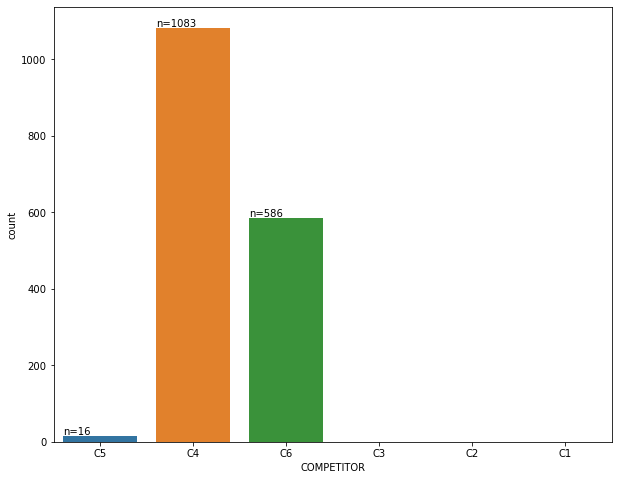

Vendas por produto:  P5


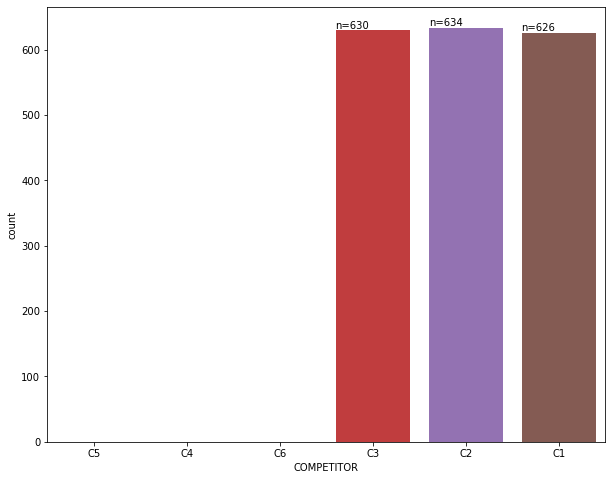

Vendas por produto:  P6


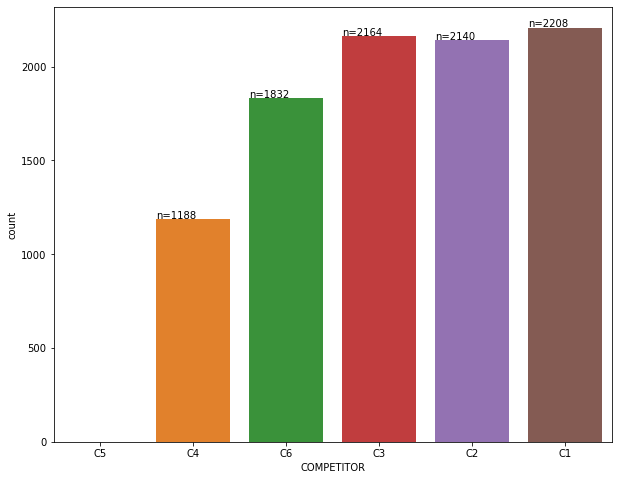

Vendas por produto:  P7


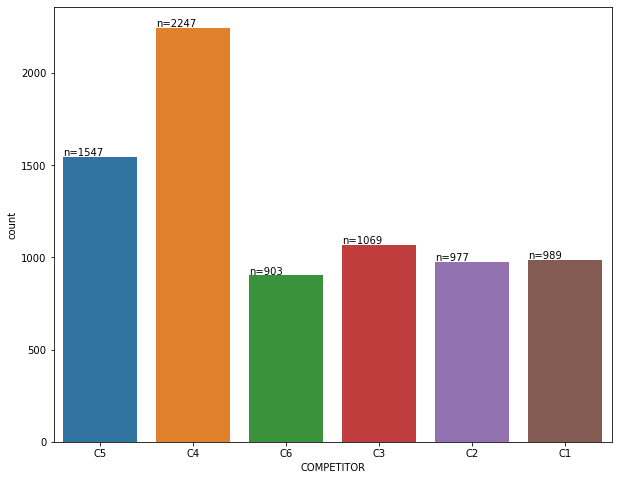

Vendas por produto:  P8


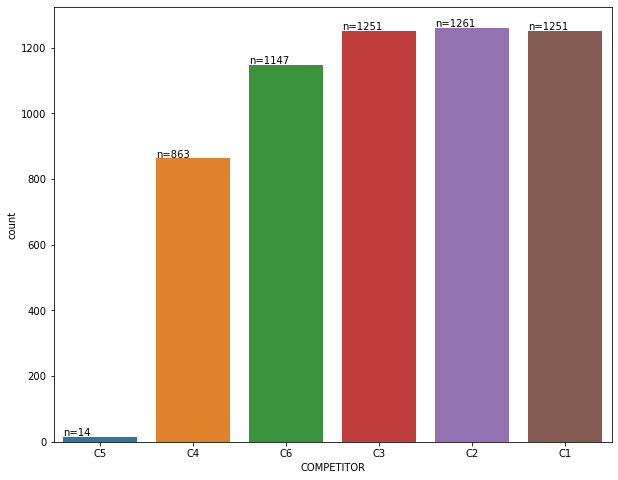

Vendas por produto:  P9


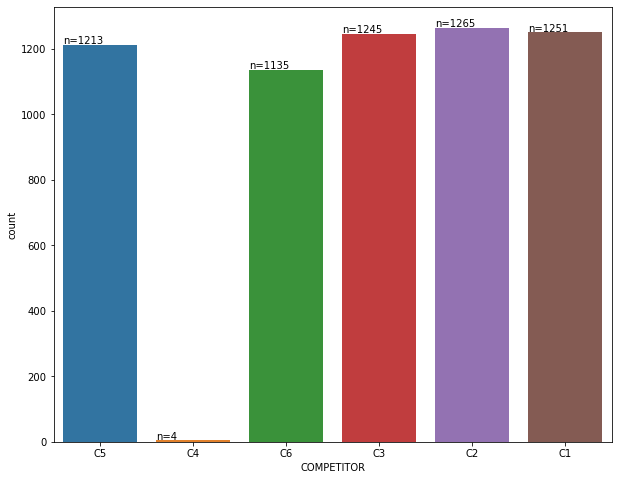

In [18]:

column_ID = df['PROD_ID'].unique()
column_ID.sort()
# len(column_ID)

for i in (column_ID):
    print('Vendas por produto: ', i)
    ax = (sns.countplot(x = 'COMPETITOR',
                  data = df.loc[df['PROD_ID'] == i],
                  order = df['COMPETITOR'].value_counts().index[::-1]))

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x(), height+ 3, 'n=%.0f'%(height))
    plt.show()


## Qual o tipo de pagamento utilizado em cada produto?

Tipos de pagamento por produto:  P1


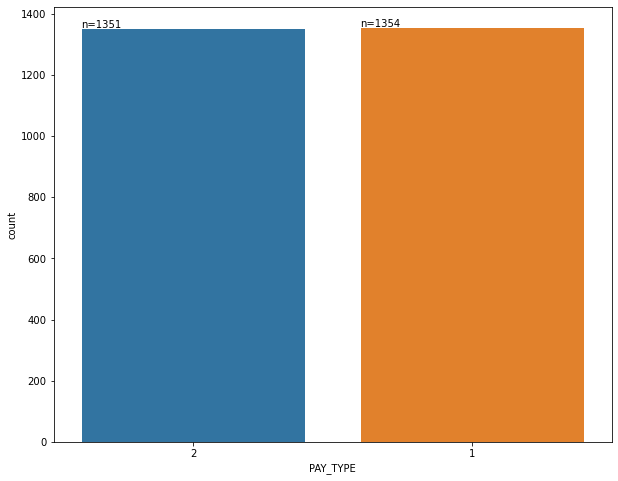

Tipos de pagamento por produto:  P2


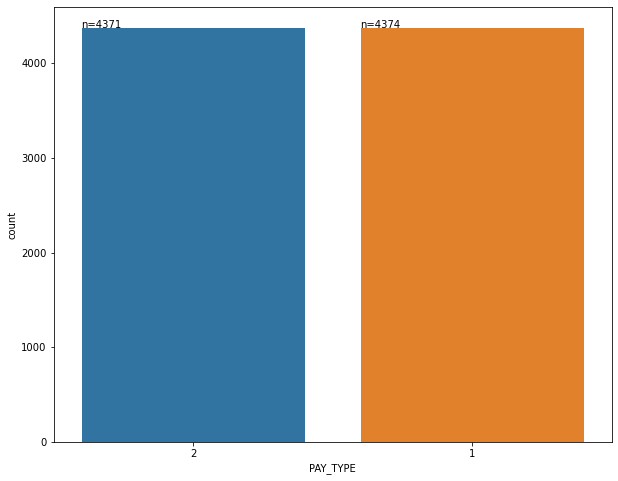

Tipos de pagamento por produto:  P3


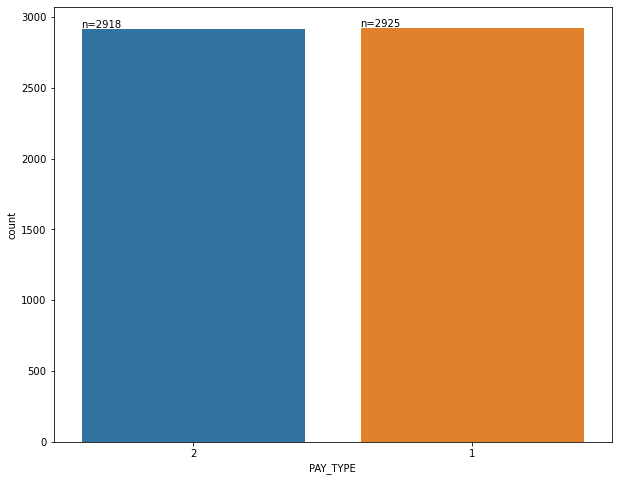

Tipos de pagamento por produto:  P4


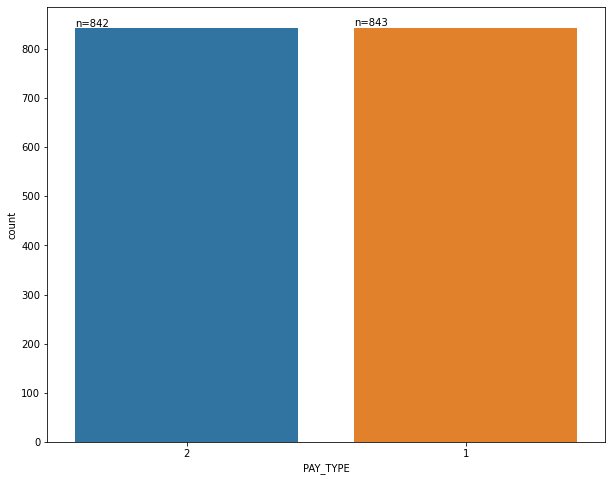

Tipos de pagamento por produto:  P5


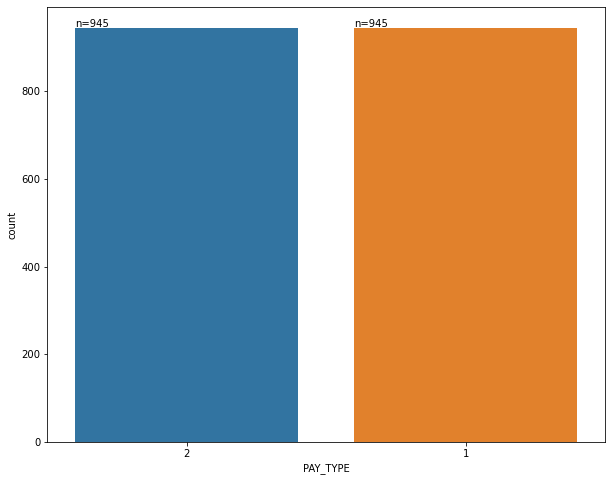

Tipos de pagamento por produto:  P6


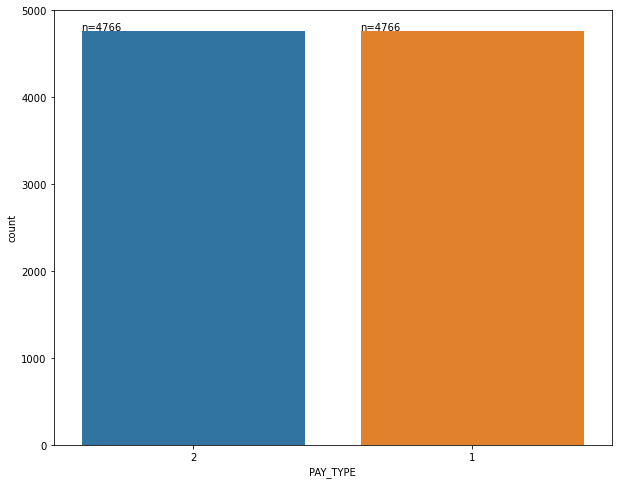

Tipos de pagamento por produto:  P7


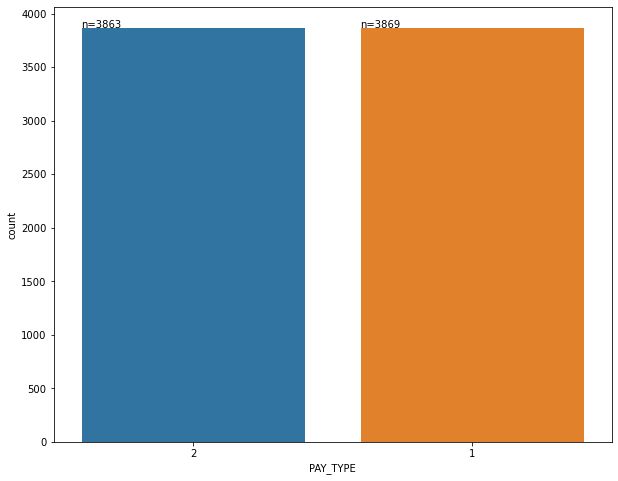

Tipos de pagamento por produto:  P8


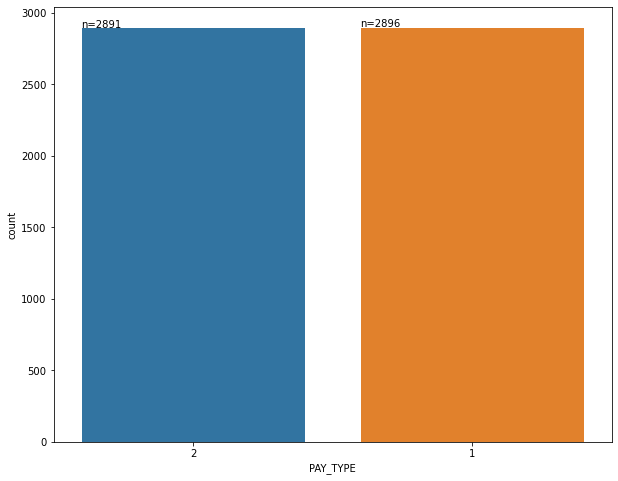

Tipos de pagamento por produto:  P9


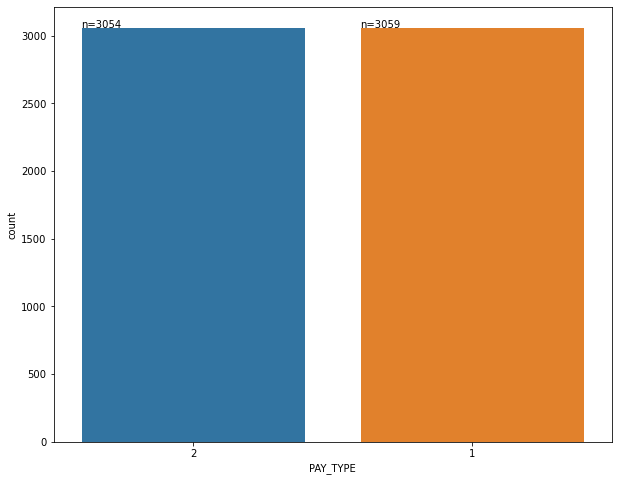

In [19]:
for i in (column_ID):
    print('Tipos de pagamento por produto: ', i)
    ax = (sns.countplot(x = 'PAY_TYPE',
                  data = df.loc[df['PROD_ID'] == i],
                  order = df['PAY_TYPE'].value_counts().index[::-1]))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x(), height+ 3, 'n=%.0f'%(height))
    plt.show()

**PAY_TYPE**

- Nota-se que a quantidade do tipo do meio de pagamento é muito próxima em cada um dos itens por isso, na minha análise vou considerar como um todo.
- Mas esse fator pode influenciar no preço final dos produtos. E poderiam ser comparados os preços por cada meio de pagamento.

## Quais Competidores tem o melhor e pior preço para cada produto?

In [20]:
column_names = ['PROD_ID', 'COMPETITOR', 'PRICE_AVG', 'BEST_PRICE', 'WORST_PRICE']
df_avg_price_competitor = pd.DataFrame(columns = column_names)
df_avg_price_competitor

,PROD_ID,COMPETITOR,PRICE_AVG,BEST_PRICE,WORST_PRICE


In [21]:
col_prod_ID = df['PROD_ID'].unique()
col_prod_ID.sort()
col_competitor = df['COMPETITOR'].unique()
col_competitor.sort()

for i in (col_prod_ID):
    for c in (col_competitor):
        avg = round(df.loc[(df['PROD_ID'] == i) & (df['COMPETITOR'] == c)]['COMPETITOR_PRICE'].mean(), 2)
        df_avg_price_competitor = df_avg_price_competitor.append({'PROD_ID': i, 'COMPETITOR': c, 'PRICE_AVG': avg, 'BEST_PRICE': 0, 'WORST_PRICE': 0}, 
                ignore_index = True)


### Removendo produtos dos competidores que não apresentaram vendas, ou seja, estão sem média


In [22]:
df_avg_price_competitor = df_avg_price_competitor.dropna()
df_avg_price_competitor = df_avg_price_competitor.reset_index(drop=True)


In [23]:
df_avg_price_competitor.head()

,PROD_ID,COMPETITOR,PRICE_AVG,BEST_PRICE,WORST_PRICE
0,P1,C1,1507.48,0,0
1,P1,C2,1527.58,0,0
2,P1,C3,1433.09,0,0
3,P1,C5,1459.47,0,0
4,P1,C6,1496.51,0,0


### Atribuindo 1 para as novas colunas BEST_PRICE e  WORST_PRICE quando o concorrente tem o melhor ou o pior preço

In [24]:
for i in (col_prod_ID):
    row_price = df_avg_price_competitor.loc[(df_avg_price_competitor['PROD_ID'] == i)]
    max_price = row_price.loc[(row_price['PRICE_AVG'] == row_price['PRICE_AVG'].max())]
    index = max_price.index  
    df_avg_price_competitor['WORST_PRICE'].iloc[index[0]] = 1
    
    min_price = row_price.loc[(row_price['PRICE_AVG'] == row_price['PRICE_AVG'].min())]
    index = min_price.index
    df_avg_price_competitor['BEST_PRICE'].iloc[index[0]] = 1

        

In [25]:
df_avg_price_competitor

,PROD_ID,COMPETITOR,PRICE_AVG,BEST_PRICE,WORST_PRICE
0,P1,C1,1507.48,0,0
1,P1,C2,1527.58,0,1
2,P1,C3,1433.09,1,0
3,P1,C5,1459.47,0,0
4,P1,C6,1496.51,0,0
5,P2,C1,710.94,0,0
6,P2,C2,709.16,0,0
7,P2,C3,695.07,1,0
8,P2,C4,750.69,0,0
9,P2,C5,784.73,0,0


### Na média o melhor preço dos produtos em cada concorrente são:

Gráfico Preço Médio  por produto:  P1


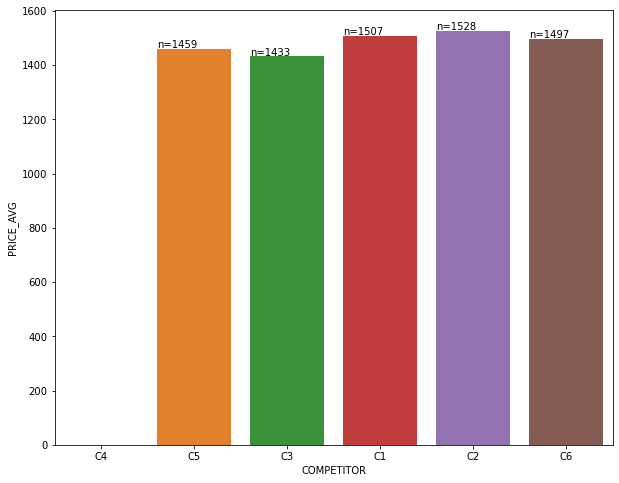

Gráfico Preço Médio  por produto:  P2


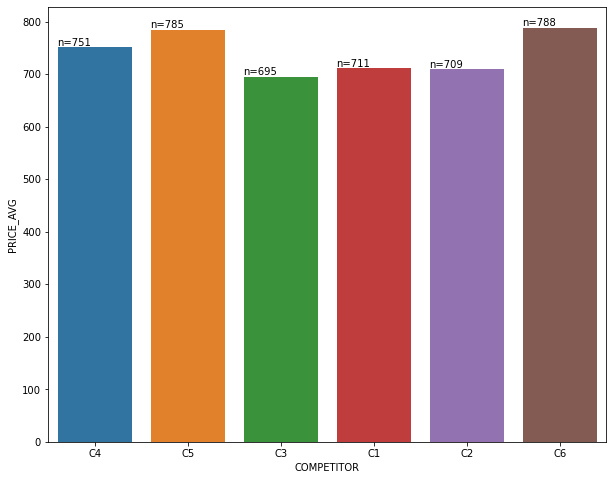

Gráfico Preço Médio  por produto:  P3


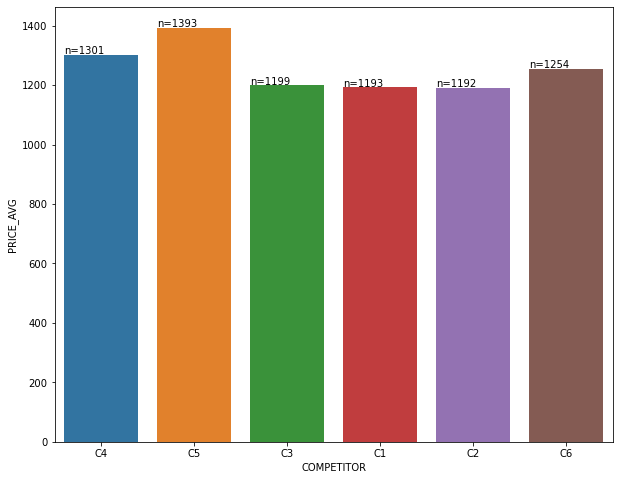

Gráfico Preço Médio  por produto:  P4


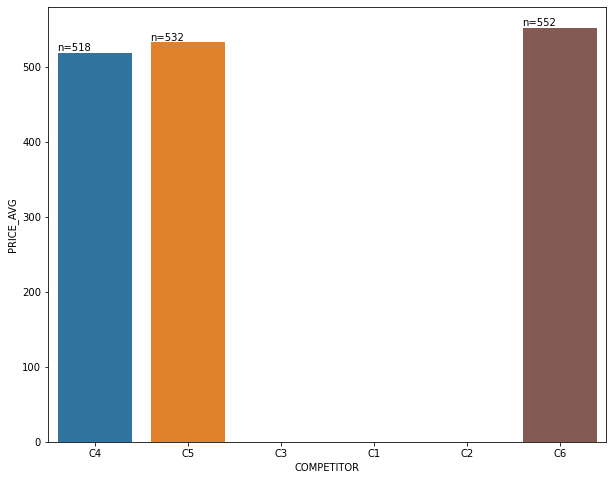

Gráfico Preço Médio  por produto:  P5


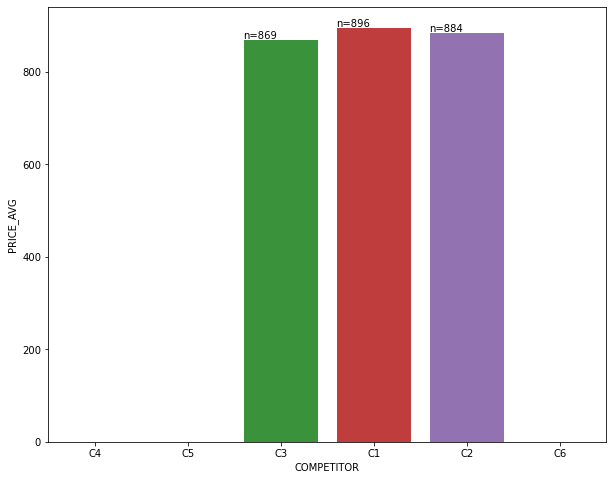

Gráfico Preço Médio  por produto:  P6


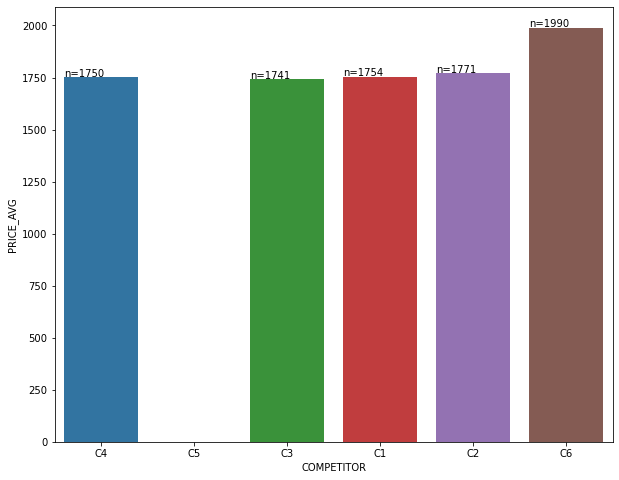

Gráfico Preço Médio  por produto:  P7


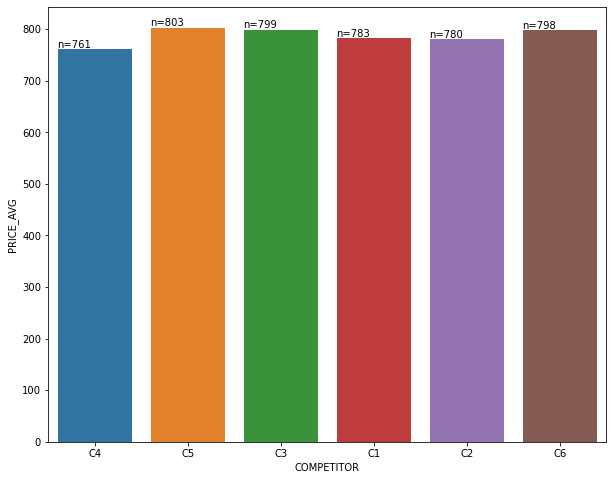

Gráfico Preço Médio  por produto:  P8


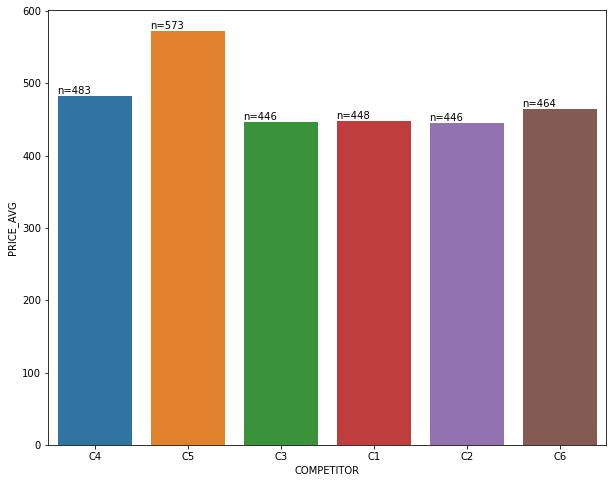

Gráfico Preço Médio  por produto:  P9


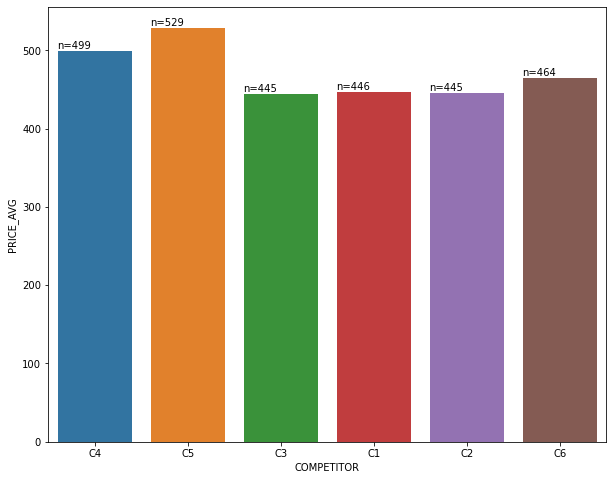

In [26]:
for i in (column_ID):
    print('Gráfico Preço Médio  por produto: ', i)
    ax = (sns.barplot(x="COMPETITOR",
            y="PRICE_AVG",
            data=df_avg_price_competitor.loc[df_avg_price_competitor['PROD_ID'] == i],
            order = df_avg_price_competitor['COMPETITOR'].value_counts().index[::-1]))

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x(), height+ 3, 'n=%.0f'%(height))
    plt.show()


### Concorrentes com os melhores preços médio


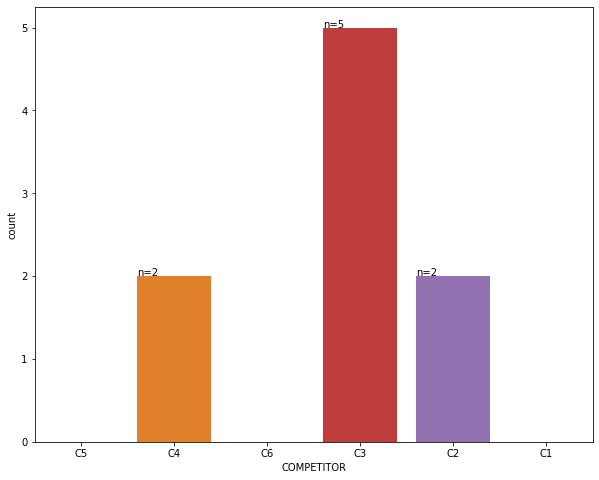

In [27]:
ax = (sns.countplot(x = 'COMPETITOR',
                  data=df_avg_price_competitor.loc[df_avg_price_competitor['BEST_PRICE'] == 1],
                  order = df['COMPETITOR'].value_counts().index[::-1]))
for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x(), height, 'n=%.0f'%(height))
plt.show()

- C3 tem 4 melhores preços
- C4 tem 2 melhores preços
- C2 tem 2 melhores preços


### Concorrentes com os piortes preços médio


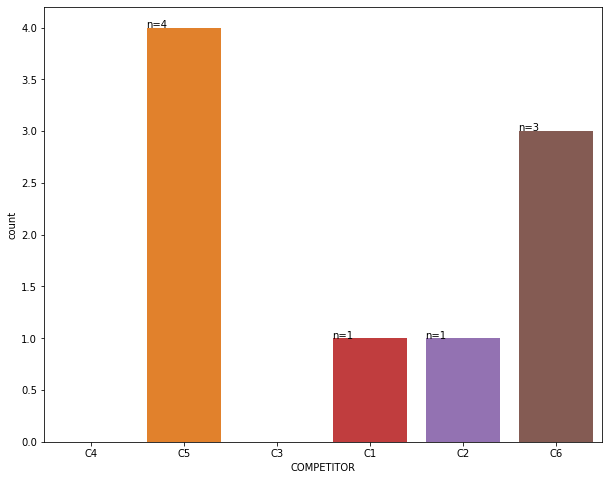

In [28]:
ax = (sns.countplot(x = 'COMPETITOR',
                  data=df_avg_price_competitor.loc[df_avg_price_competitor['WORST_PRICE'] == 1],
                  order = df_avg_price_competitor['COMPETITOR'].value_counts().index[::-1]))
for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x(), height, 'n=%.0f'%(height))

**Concorrentes com os piortes preços médio** 
- C5 tem 4 piores preços
- C6 tem 3 piores preços
- C2 tem 1 piores preços
- C1 tem 1 piores preços